In [67]:
# For this notebook to run with updated APIs, we need torch 1.12+ and torchvision 0.13+
try:
    import torch
    import torchvision
    assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
    assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")
except:
    print(f"[INFO] torch/torchvision versions not as required, installing nightly versions.")
    !pip3 install -U torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
    import torch
    import torchvision
    print(f"torch version: {torch.__version__}")
    print(f"torchvision version: {torchvision.__version__}")

torch version: 2.1.2+cu118
torchvision version: 0.16.2+cu118


In [68]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular or helper_functions scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !mv pytorch-deep-learning/helper_functions.py . # get the helper_functions.py script
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine
    from helper_functions import download_data, set_seeds, plot_loss_curves

In [69]:
image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [70]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [71]:
# Setup device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

## 2. Create Datasets and DataLoaders

In [72]:
from going_modular.going_modular import data_setup

# Create image size
IMG_SIZE = 224

# Create transforms pipeline
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

print(f'Manually created transforms: {manual_transforms}')

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
)


In [73]:
# Create a batch size of 32(the paper uses 4096 but this may be too big for our smaller hardware...can always scale up later)
BATCH_SIZE = 32

# Create DataLoaders
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

len(train_dataloader), len(test_dataloader), class_names

(8, 3, ['pizza', 'steak', 'sushi'])

### 2.3 Visualize a single image

In [74]:
image_batch, label_batch = next(iter(train_dataloader))

image, label = image_batch[0], label_batch[0]

image.shape, label

(torch.Size([3, 224, 224]), tensor(0))

(-0.5, 223.5, 223.5, -0.5)

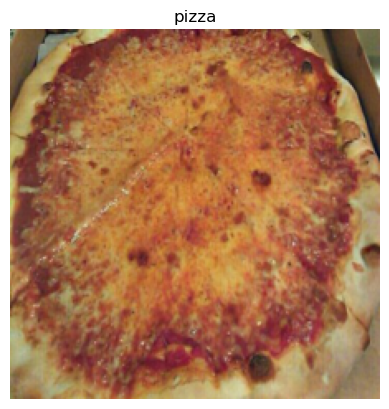

In [75]:
# Plot using matplotlib

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)


# Replicating ViT

## Equation 1: Split data into patches and creating class positioning and embedding

(-0.5, 223.5, 223.5, -0.5)

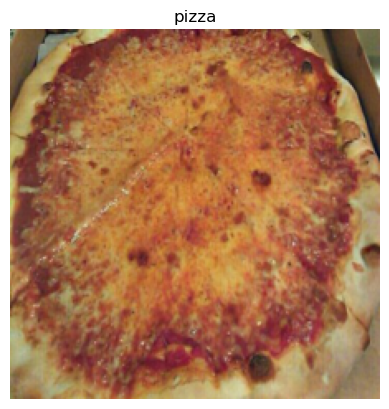

In [76]:
# Turning a single image into patches

plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)

In [77]:
image.shape

torch.Size([3, 224, 224])

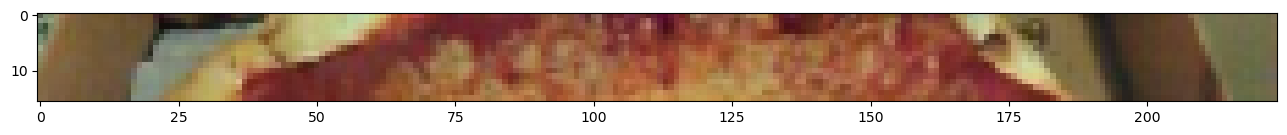

In [78]:
# Get the top row
image_permuted = image.permute(1, 2, 0)
patch_size=16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :])

In [79]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
num_patches
assert img_size % patch_size == 0

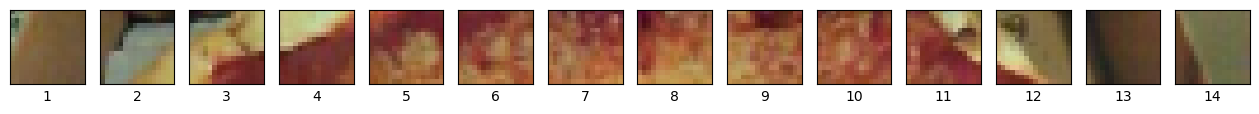

In [80]:
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size,
                        sharex=True,
                        sharey=True,
                        figsize=(patch_size, patch_size))
# iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :])
    axs[i].set_xlabel(i+1)
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0      
Number of patches per column: 14.0      
Total patches: 196.0      
Patch size: 16 pixels x 16 pixels


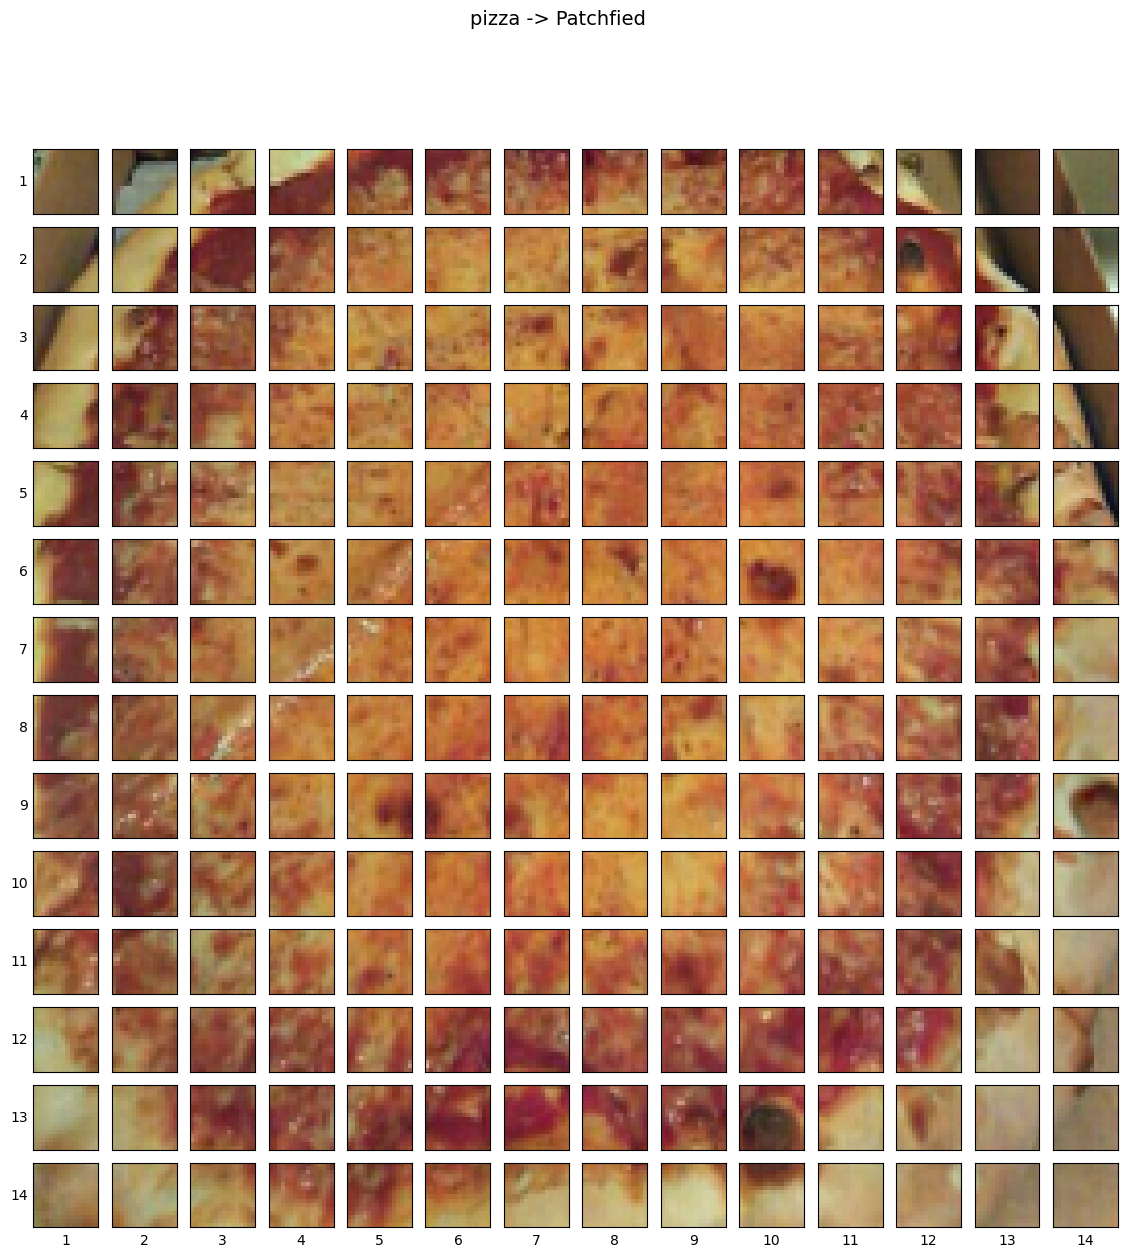

In [81]:
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, 'Image size must be divisible by patch size'
print(f'Number of patches per row: {num_patches}\
      \nNumber of patches per column: {num_patches}\
      \nTotal patches: {num_patches*num_patches}\
      \nPatch size: {patch_size} pixels x {patch_size} pixels')

fig, axs = plt.subplots(nrows=img_size // patch_size,
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True
                        )

for i, patch_height in enumerate(range(0, img_size, patch_size)):
    for j, patch_width in enumerate(range(0, img_size, patch_size)):
            axs[i,j].imshow(image_permuted[patch_height:patch_height+patch_size,
                                       patch_width:patch_width+patch_size,
                                       :])
            axs[i, j].set_ylabel(i+1,
                             rotation='horizontal',
                             horizontalalignment='right',
                             verticalalignment='center')
            axs[i, j].set_xlabel(j+1)
            axs[i, j].set_xticks([])
            axs[i, j].set_yticks([])
            axs[i, j].label_outer()

fig.suptitle(f'{class_names[label]} -> Patchfied', fontsize=14)
plt.show()

(-0.5, 223.5, 223.5, -0.5)

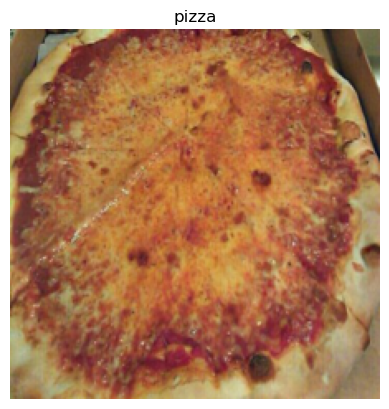

In [82]:
# Create conv2d layer to turn image into patches of learnable feature maps (embeddings)

from torch import nn

patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

plt.imshow(image.permute(1, 2, 0))
plt.title(class_names[label])
plt.axis(False)

In [83]:
image_out_of_conv = conv2d(image.unsqueeze(0))
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [84]:
import random
random_indexes = random.sample(range(0, 758), k=5)
print(f'Showing random convolutional feature maps from indexes: {random_indexes}')

Showing random convolutional feature maps from indexes: [346, 703, 522, 680, 509]


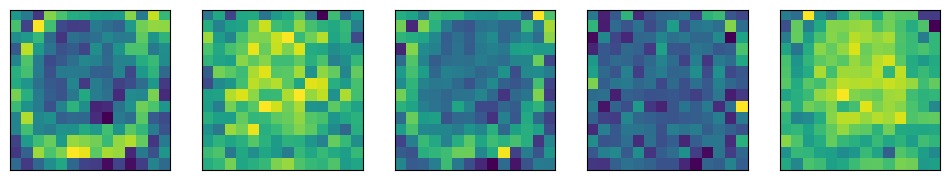

In [85]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12,12))

for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :]
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);

In [86]:
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map

tensor([[[ 0.0601,  0.1965,  0.2412, -0.1999,  0.0895,  0.1833,  0.0802,
           0.2358,  0.1443,  0.1350,  0.1392,  0.2295,  0.1000,  0.0184],
         [ 0.0280,  0.1177,  0.0764,  0.1164,  0.1289,  0.0694,  0.1579,
           0.0522,  0.0294,  0.1477,  0.0955,  0.0927,  0.2108,  0.1434],
         [ 0.0206,  0.1608,  0.0354,  0.1022,  0.0883,  0.0359,  0.0872,
           0.0104,  0.1146,  0.0235,  0.0989,  0.0650,  0.1502,  0.1872],
         [ 0.0453,  0.0780,  0.0708,  0.1219,  0.0887,  0.1010,  0.0490,
           0.0152,  0.0767,  0.0746,  0.0868,  0.1785,  0.1845, -0.0004],
         [ 0.0952,  0.1041,  0.1509,  0.1333,  0.1080,  0.0199,  0.0856,
           0.1051,  0.1024,  0.1175,  0.1412,  0.1241,  0.1120,  0.1392],
         [ 0.2181,  0.0297,  0.0960,  0.1190,  0.0658,  0.0851,  0.1067,
           0.0824,  0.1276,  0.0782,  0.1338,  0.1228,  0.1840,  0.0473],
         [ 0.0609,  0.1260,  0.1365,  0.1071,  0.1208,  0.1329,  0.0400,
           0.0702,  0.1046,  0.1114,  0.0717,

In [87]:
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


In [88]:
from torch import nn
flatten = nn.Flatten(start_dim=2,
                           end_dim=3)
flatten(image_out_of_conv).shape

torch.Size([1, 768, 196])

Original image shape: torch.Size([3, 224, 224])
Image feature map (patches) shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


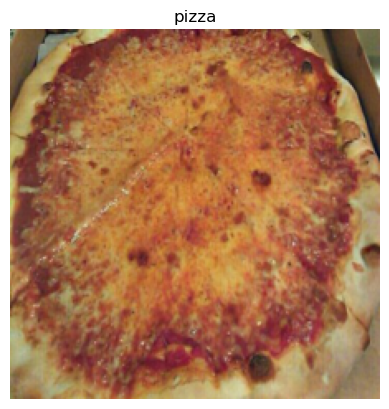

In [89]:
plt.imshow(image.permute(1,2,0))
plt.title(class_names[label])
plt.axis(False)
print(f'Original image shape: {image.shape}')

image_out_of_conv_flattened = conv2d(image.unsqueeze(0))
print(f'Image feature map (patches) shape: {image_out_of_conv_flattened.shape}')

image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [90]:
image_out_of_conv_flattened.permute(0, 2, 1).shape
image_out_of_conv_flattened_permuted = image_out_of_conv_flattened.permute(0, 2, 1)

Text(0.5, 1.0, 'Flattened feature map shape: torch.Size([1, 196])')

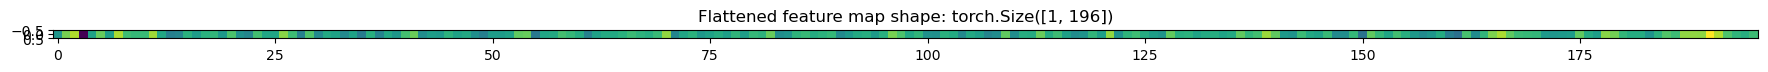

In [91]:
single_flattened_feature_map = image_out_of_conv_flattened_permuted[:, :, 0]


plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f'Flattened feature map shape: {single_flattened_feature_map.shape}')

In [92]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels:int=3,
                 patch_size=16,
                 embedding_dim:int=768):
        super().__init__()

        self.patch_size = patch_size

        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,  
                                 padding=0)
        
        self.flatten = nn.Flatten(start_dim=2,
                                  end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f'Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}'

        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

In [93]:
set_seeds()

patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f'Input image size: {image.unsqueeze(0).shape}')
patch_embedded_image = patchify(image.unsqueeze(0))
print(f'Output patch embedding sequence shape: {patch_embedded_image.shape}')

Input image size: torch.Size([1, 3, 224, 224])
Output patch embedding sequence shape: torch.Size([1, 196, 768])


In [95]:
rand_image_tensor = torch.randn(1, 3, 224, 224)
rand_image_tensor_bad = torch.randn(1, 3, 250, 250)

# patchify(rand_image_tensor_bad)

In [96]:
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]
batch_size, embedding_dimension

(1, 768)

In [98]:
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)

class_token.shape

torch.Size([1, 1, 768])

In [99]:
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1)

print(patch_embedded_image_with_class_embedding)
print(f"Patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")


tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.3902,  0.0184, -0.0995,  ...,  0.2769, -0.2167,  0.2311],
         [-0.5393, -0.0262, -0.1467,  ...,  0.2823, -0.1606,  0.1711],
         ...,
         [-0.5424,  0.1774, -0.1478,  ...,  0.4131, -0.3413,  0.2545],
         [-0.5112,  0.0919, -0.1420,  ...,  0.3481, -0.2482,  0.2371],
         [-0.5819,  0.1205, -0.1569,  ...,  0.3898, -0.2699,  0.1897]]],
       grad_fn=<CatBackward0>)
Patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


In [105]:
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.3902,  0.0184, -0.0995,  ...,  0.2769, -0.2167,  0.2311],
          [-0.5393, -0.0262, -0.1467,  ...,  0.2823, -0.1606,  0.1711],
          ...,
          [-0.5424,  0.1774, -0.1478,  ...,  0.4131, -0.3413,  0.2545],
          [-0.5112,  0.0919, -0.1420,  ...,  0.3481, -0.2482,  0.2371],
          [-0.5819,  0.1205, -0.1569,  ...,  0.3898, -0.2699,  0.1897]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

In [106]:
height, width = image.shape[1], image.shape[2]

number_of_patches = int((height * width) / patch_size **2)

embedding_dimension = patch_embedded_image_with_class_embedding.shape[-1]

position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                             requires_grad=True)

In [108]:
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding.shape)
patch_and_position_embedding

torch.Size([1, 197, 768])


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.6098, 1.0184, 0.9005,  ..., 1.2769, 0.7833, 1.2311],
         [0.4607, 0.9738, 0.8533,  ..., 1.2823, 0.8394, 1.1711],
         ...,
         [0.4576, 1.1774, 0.8522,  ..., 1.4131, 0.6587, 1.2545],
         [0.4888, 1.0919, 0.8580,  ..., 1.3481, 0.7518, 1.2371],
         [0.4181, 1.1205, 0.8431,  ..., 1.3898, 0.7301, 1.1897]]],
       grad_fn=<AddBackward0>)

In [112]:
set_seeds()

patch_size = 16

print(f'Image tenshor shape: {image.shape}')
height, width = image.shape[1], image.shape[2]

x = image.unsqueeze(0)
print(f'Input image shape: {x.shape}')

patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

patch_embedding = patch_embedding_layer(x)
print(f'Patch embedding shape: {patch_embedding.shape}')

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True)
print(f'Class token embedding shape: {class_token.shape}')

patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f'Patch embedding witch class token shape: {patch_embedding_class_token.shape}')

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f'Patch and position embedding shape: {patch_and_position_embedding.shape}')

Image tenshor shape: torch.Size([3, 224, 224])
Input image shape: torch.Size([1, 3, 224, 224])
Patch embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding witch class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])
